### Install required packages 




In [18]:
# pip install torch
# pip install torchvision 
# pip install torchaudio
#!pip install transformers
# !pip install biopython
# !pip install --upgrade jupyter

In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from Bio import SeqIO
import pandas as pd
import os
import gzip
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformer1 import (
    FASTAReader,
    KmerTokenizer,
    DNABPETokenizer,
    OneHotEncoder,
    DNASequenceDataset,
    DNATransformerEncoder,
    DNATransformerOneHot,
    collate_fn_tokens,
    collate_fn_onehot,
    train_epoch,
    evaluate
)



In [51]:
#Get Statistics

# stats = get_sequence_stats(file_path)
# print(stats)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [25]:
# Option 1: Read from your actual FASTA file
# Uncomment and replace with your file path
fasta_reader = FASTAReader("SRR31370167.fasta")
sequences_data = fasta_reader.read_sequences(limit=100)
# 
# # Display sequence information
for i, seq in enumerate(sequences_data[:3]):
    print(f"\nSequence {i+1}:")
    print(f"  ID: {seq['id']}")
    print(f"  V Number: {seq['v_number']}")
    print(f"  Sample: {seq['sample_number']}")
    print(f"  Length: {seq['length']:,} bases")
    print(f"  First 50 bases: {seq['sequence'][:50]}")
# 
# # Get statistics
stats = fasta_reader.get_sequence_stats()
print(f"\nDataset Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value:,.0f}")
# 
sequences = [seq['sequence'] for seq in sequences_data]

# Option 2: Use example sequences
# sequences = [
#     "ATGCTAGCTAGCTAGCTAGCTAATGCTAGCGATCGATCGTAGCTAGCTGATCGATCGATCGATCGTAGCTAGCTAGCTAGCTA",
#     "GGCTACGTTACGACGTAACGTACGATCGATCGATCGTAGCTAGCTACGATCGATCGACGATCGATCGTAGCTAGCTAGCTAGC",
#     "TTACTGACCTGAACCTGACCTACGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTAGCTAGCTAGCTAGC",
#     "ACGTACGTACGTACGTACGTACGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTAGCTAGCTAGCTAGCT",
#     "ATGCGGATCCGATCGATCGATCGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTAGCTAGCTAGCTAGCT",
#     "GGCATGCTAGCATCGATGCATGCGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTAGCTAGCTAGCTAGC",
#     "TTACGATCGATCGTGCACGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTAGCTAGCTAGCTAGCT",
#     "CGATCGATCGATCGTAGCTAGCTACGATCGATCGATCGATCGATCGATCGTAGCTAGCTAGCTAGCTAGCTACGATCGATCGTA",
# ] * 10  # Replicate for more data

print(f"Loaded {len(sequences)} sequences")
print(f"Average length: {np.mean([len(s) for s in sequences]):.0f} bases")



Sequence 1:
  ID: SRR31370167.1
  V Number: SRR31370167.1
  Sample: 
  Length: 251 bases
  First 50 bases: TTTCTTTCCAGTCACGGCTATTGCTTACCCTTTTCTTTTTTTCTCTTCCG

Sequence 2:
  ID: SRR31370167.1
  V Number: SRR31370167.1
  Sample: 
  Length: 251 bases
  First 50 bases: TCTCTTACTATTCCCTTCCTTTTCTTCTTCTTTTTCTTCATAACTGTCTT

Sequence 3:
  ID: SRR31370167.2
  V Number: SRR31370167.2
  Sample: 
  Length: 250 bases
  First 50 bases: TTCCTTATTTTGAACAACGTACATTGCATCTATCACCCTTCCCGTTACTC

Dataset Statistics:
  total_sequences: 830,298
  min_length: 35
  max_length: 251
  mean_length: 241
  median_length: 251
Loaded 100 sequences
Average length: 244 bases


In [5]:
#K-mers tokenization 
# Create k-mer tokenizer
k = 3
stride = 3  # 1 for overlapping, k for non-overlapping

kmer_tokenizer = KmerTokenizer(k=k, stride=stride)
kmer_tokenizer.build_vocab(sequences)

print(f"K-mer settings: k={k}, stride={stride}")
print(f"Vocabulary size: {len(kmer_tokenizer.vocab)}")
print(f"\nSpecial tokens: {kmer_tokenizer.special_tokens}")
print(f"\nSample k-mers from vocabulary:")
sample_kmers = list(kmer_tokenizer.vocab.keys())[8:18]
for kmer in sample_kmers:
    print(f"  {kmer}: {kmer_tokenizer.vocab[kmer]}")

# Test encoding/decoding
test_seq = sequences[0][:60]
encoded = kmer_tokenizer.encode(test_seq)
decoded = kmer_tokenizer.decode(encoded)

print(f"\nTest Sequence: {test_seq}")
print(f"Encoded IDs:   {encoded}")
print(f"Decoded:       {decoded}")
print(f"Match: {test_seq[:len(decoded)] == decoded}")





K-mer settings: k=3, stride=3
Vocabulary size: 74

Special tokens: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[GAP]', '[BOS]', '[EOS]']

Sample k-mers from vocabulary:
  TAA: 8
  AAA: 9
  CCA: 10
  GAA: 11
  AAC: 12
  CGA: 13
  TGA: 14
  AAT: 15
  AGA: 16
  ATC: 17

Test Sequence: TAAAAACCAGAAAACCGATGAAATAGAATCGATTGAACAGTTAAAAGATTTTGCCTCACA
Encoded IDs:   [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 14, 19, 20, 9, 16, 21, 22, 23, 19]
Decoded:       TAAAAACCAGAAAACCGATGAAATAGAATCGATTGAACAGTTAAAAGATTTTGCCTCACA
Match: True


Top 10 most frequent k-mers:
  TTT: 53,107 occurrences
  AAA: 52,769 occurrences
  ATT: 39,870 occurrences
  AAT: 39,421 occurrences
  TTA: 35,846 occurrences
  TAA: 34,936 occurrences
  TTG: 32,372 occurrences
  CAA: 31,662 occurrences
  TAT: 28,072 occurrences
  ATA: 27,379 occurrences


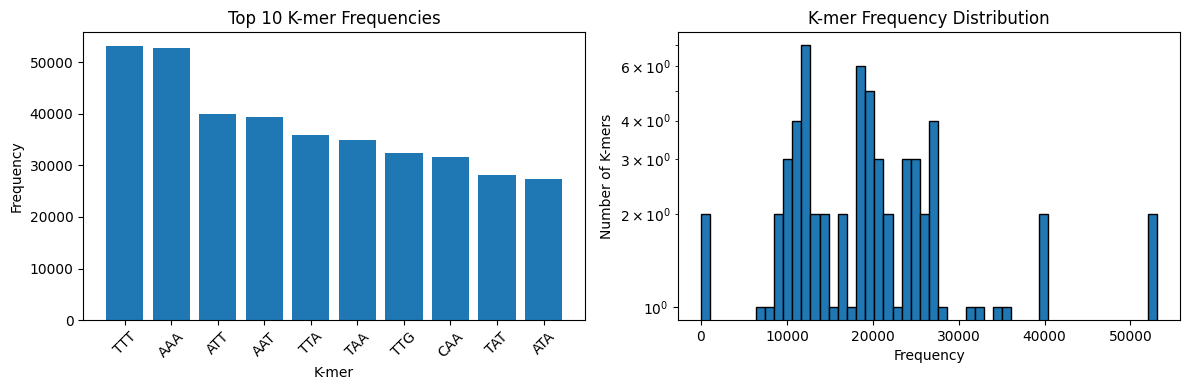

In [6]:
# Count k-mer frequencies
from collections import Counter

all_kmers = []
for seq in sequences:
    all_kmers.extend(kmer_tokenizer.sequence_to_kmers(seq))

kmer_counts = Counter(all_kmers)
top_kmers = kmer_counts.most_common(10)

print("Top 10 most frequent k-mers:")
for kmer, count in top_kmers:
    print(f"  {kmer}: {count:,} occurrences")

# Visualize k-mer distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
counts = [count for _, count in top_kmers]
labels = [kmer for kmer, _ in top_kmers]
plt.bar(range(len(counts)), counts)
plt.xlabel('K-mer')
plt.ylabel('Frequency')
plt.title('Top 10 K-mer Frequencies')
plt.xticks(range(len(labels)), labels, rotation=45)

plt.subplot(1, 2, 2)
freq_distribution = list(kmer_counts.values())
plt.hist(freq_distribution, bins=50, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of K-mers')
plt.title('K-mer Frequency Distribution')
plt.yscale('log')

plt.tight_layout()
plt.show()
    


Training BPE tokenizer...



Training complete!

Test Sequence: TAAAAACCAGAAAACCGATGAAATAGAATCGATTGAACAGTTAAAAGATTTTGCCTCACA
Encoded IDs:   [11, 311, 42, 470, 30, 138, 310, 199, 22, 135, 36, 161, 215, 40, 7]
Decoded:       t aaaaac cag aaaacc gat gaaat agaat cgatt gaa cagtt aaaa gatttt gcct cac a
Match: False

Compression comparison:
  Original length: 60 bases
  K-mer tokens:    20 tokens
  BPE tokens:      15 tokens
  BPE compression: 4.00x
One-hot encoding example:
Sequence: ATGCN

Encoded shape: (5, 4)

Encoding (A, C, G, T):
  A: [1. 0. 0. 0.]
  T: [0. 0. 0. 1.]
  G: [0. 0. 1. 0.]
  C: [0. 1. 0. 0.]
  N: [0. 0. 0. 0.]


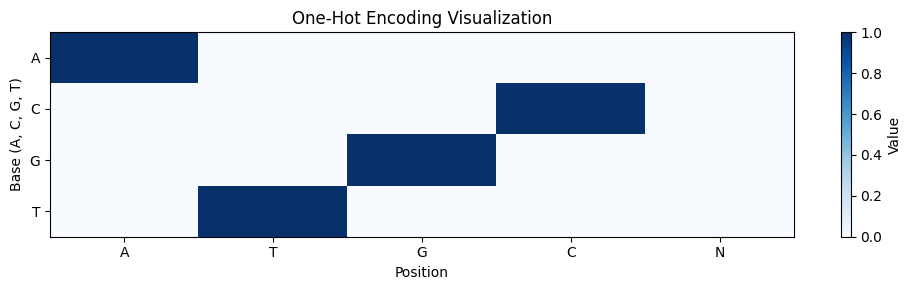

In [7]:
# Create and train BPE tokenizer
bpe_tokenizer = DNABPETokenizer(vocab_size=1000, min_frequency=2)

print("Training BPE tokenizer...")
bpe_tokenizer.train(sequences)
print("Training complete!")

# Test encoding/decoding
test_seq = sequences[0][:60]
encoded_bpe = bpe_tokenizer.encode(test_seq)
decoded_bpe = bpe_tokenizer.decode(encoded_bpe)

print(f"\nTest Sequence: {test_seq}")
print(f"Encoded IDs:   {encoded_bpe}")
print(f"Decoded:       {decoded_bpe}")
print(f"Match: {test_seq == decoded_bpe}")

# Compare compression
print(f"\nCompression comparison:")
print(f"  Original length: {len(test_seq)} bases")
print(f"  K-mer tokens:    {len(encoded)} tokens")
print(f"  BPE tokens:      {len(encoded_bpe)} tokens")
print(f"  BPE compression: {len(test_seq) / len(encoded_bpe):.2f}x")


# Create one-hot encoder
onehot_encoder = OneHotEncoder(include_ambiguous=True)

# Test encoding
test_seq = "ATGCN"
encoded_onehot = onehot_encoder.encode(test_seq)

print("One-hot encoding example:")
print(f"Sequence: {test_seq}")
print(f"\nEncoded shape: {encoded_onehot.shape}")
print(f"\nEncoding (A, C, G, T):")
for i, base in enumerate(test_seq):
    print(f"  {base}: {encoded_onehot[i]}")

# Visualize one-hot encoding
plt.figure(figsize=(10, 3))
plt.imshow(encoded_onehot.T, cmap='Blues', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Position')
plt.ylabel('Base (A, C, G, T)')
plt.title('One-Hot Encoding Visualization')
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'T'])
plt.xticks(range(len(test_seq)), list(test_seq))
plt.tight_layout()
plt.show()



Decoded: ATGCN
Match: False
Encoding method: kmer
Training sequences: 51
Validation sequences: 13
Training batches: 4
Validation batches: 1
Model: DNATransformerEncoder
Vocabulary size: 74
Model parameters: 415,562

Model architecture:
DNATransformerEncoder(
  (embedding): Embedding(74, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): D

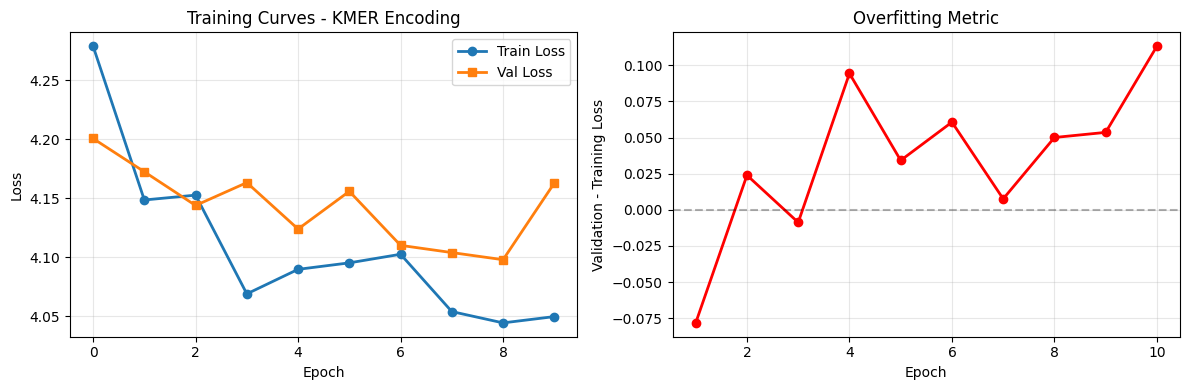

Plot saved: training_curves_kmer.png


In [15]:
# Test decoding
decoded_onehot = onehot_encoder.decode(encoded_onehot)
print(f"\nDecoded: {decoded_onehot}")
print(f"Match: {test_seq == decoded_onehot}")


# Configuration
ENCODING_TYPE = 'kmer'  # Change to 'bpe' or 'onehot' to try different methods
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 16

# Choose tokenizer based on encoding type
if ENCODING_TYPE == 'kmer':
    tokenizer = kmer_tokenizer
elif ENCODING_TYPE == 'bpe':
    tokenizer = bpe_tokenizer
else:  # onehot
    tokenizer = None

# Split data
split_idx = int(0.8 * len(sequences))
train_sequences = sequences[:split_idx]
val_sequences = sequences[split_idx:]

print(f"Encoding method: {ENCODING_TYPE}")
print(f"Training sequences: {len(train_sequences)}")
print(f"Validation sequences: {len(val_sequences)}")

# Create datasets
train_dataset = DNASequenceDataset(
    train_sequences,
    tokenizer,
    max_length=MAX_SEQ_LENGTH,
    encoding_type=ENCODING_TYPE
)

val_dataset = DNASequenceDataset(
    val_sequences,
    tokenizer,
    max_length=MAX_SEQ_LENGTH,
    encoding_type=ENCODING_TYPE
)

# Create dataloaders
collate_fn = collate_fn_onehot if ENCODING_TYPE == 'onehot' else collate_fn_tokens

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


# Model hyperparameters
D_MODEL = 128
NHEAD = 4
NUM_LAYERS = 2
DIM_FEEDFORWARD = 512
DROPOUT = 0.1

# Create model based on encoding type
if ENCODING_TYPE == 'onehot':
    model = DNATransformerOneHot(
        input_dim=4,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT,
        num_classes=4
    )
    vocab_size = 4
else:
    vocab_size = len(tokenizer.vocab)
    model = DNATransformerEncoder(
        vocab_size=vocab_size,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT,
        max_seq_length=MAX_SEQ_LENGTH
    )

model = model.to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model.__class__.__name__}")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Model parameters: {num_params:,}")
print(f"\nModel architecture:")
print(model)


# Training setup
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, #verbose=True
)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"Training for {NUM_EPOCHS} epochs...")
print("=" * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, criterion, device, ENCODING_TYPE
    )
    train_losses.append(train_loss)
    
    # Validate
    val_loss = evaluate(
        model, val_loader, criterion, device, ENCODING_TYPE
    )
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f'best_model_{ENCODING_TYPE}.pt')
        print("✓ Saved best model")

print("\n" + "=" * 70)
print(f"Training complete! Best validation loss: {best_val_loss:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(val_losses, label='Val Loss', marker='s', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Curves - {ENCODING_TYPE.upper()} Encoding')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
epochs = range(1, len(train_losses) + 1)
overfitting = np.array(val_losses) - np.array(train_losses)
plt.plot(epochs, overfitting, marker='o', linewidth=2, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Validation - Training Loss')
plt.title('Overfitting Metric')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'training_curves_{ENCODING_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved: training_curves_{ENCODING_TYPE}.png")


In [16]:
# Load best model
checkpoint = torch.load(f'best_model_{ENCODING_TYPE}.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test on a few sequences
test_sequences = val_sequences[:3]

print("Testing model predictions:")
print("=" * 70)

for i, test_seq in enumerate(test_sequences):
    test_seq = test_seq[:100]  # Use first 100 bases
    
    print(f"\nTest Sequence {i+1}:")
    print("-" * 70)
    
    if ENCODING_TYPE == 'onehot':
        # One-hot encoding
        encoder = OneHotEncoder()
        test_input = encoder.encode_tensor(test_seq).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(test_input)
        
        predicted = torch.argmax(output, dim=-1)[0]
        bases = ['A', 'C', 'G', 'T']
        predicted_seq = ''.join([bases[i] for i in predicted.cpu().numpy()])
    else:
        # Token-based encoding
        test_input = torch.tensor(tokenizer.encode(test_seq)).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(test_input)
        
        predicted = torch.argmax(output, dim=-1)[0]
        predicted_seq = tokenizer.decode(predicted.cpu().tolist())
    
    # Calculate accuracy
    min_len = min(len(test_seq), len(predicted_seq))
    matches = sum(1 for j in range(min_len) if test_seq[j] == predicted_seq[j])
    accuracy = matches / min_len

    print(f"Original:  {test_seq[:50]}...")
    print(f"Predicted: {predicted_seq[:50]}...")
    print(f"Accuracy:  {accuracy:.2%} ({matches}/{min_len} bases correct)")



Testing model predictions:

Test Sequence 1:
----------------------------------------------------------------------
Original:  ATTCTTTAATTGTGCATCTTCCATCCTTCAAGCACACTTGAACAAACTCA...
Predicted: CAATTTGAATTAATTTTTTTTCAAAAATAAGATTAATTTTTTATTTTTCA...
Accuracy:  31.31% (31/99 bases correct)

Test Sequence 2:
----------------------------------------------------------------------
Original:  GCTAAATCAGCTTTCGCTTTAGCCAATGCCATAGAGTTTTCGAGAGTTCG...
Predicted: CAACAATAACAATTTCAATAAATTTTTATTCAATTTTAAATTTTTTAATT...
Accuracy:  25.25% (25/99 bases correct)

Test Sequence 3:
----------------------------------------------------------------------
Original:  AACTGCCCTACTTGCAAGAAGATGATTCCTGTTGACCGTTCAAAAATCAA...
Predicted: CAATTTTTTTTTTTTATTATTTAACAAAAATAATTTATTTAACAATTGCA...
Accuracy:  30.30% (30/99 bases correct)


In [17]:
# Save tokenizer/encoder
if ENCODING_TYPE == 'kmer':
    kmer_tokenizer.save_vocab(f'kmer_vocab_k{k}.json')
    print(f"Saved: kmer_vocab_k{k}.json")
elif ENCODING_TYPE == 'bpe':
    bpe_tokenizer.save(f'bpe_tokenizer.json')
    print(f"Saved: bpe_tokenizer.json")

print(f"Model checkpoint: best_model_{ENCODING_TYPE}.pt")
print("\nAll files saved successfully!")

Saved: kmer_vocab_k3.json
Model checkpoint: best_model_kmer.pt

All files saved successfully!


In [40]:
#character-level tokenization
char_tokens = list(bases)
char_token_counts = pd.Series(char_tokens).value_counts()
print(char_token_counts)

T    161
A    138
C    125
G     90
Name: count, dtype: int64


In [48]:
#Bytepair Encoding
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
trainer = trainers.BpeTrainer(vocab_size=1000, min_frequency=2)
bases = str(record.seq[:])  # Convert to plain string
tokenizer.train_from_iterator([bases], trainer)

encodded = tokenizer.encode(bases)
print(encodded.tokens)
print(encodded.ids)




['Ġ', 'GTGAT', 'AT', 'ATCC', 'AA', 'TACC', 'AACT', 'ACTAA', 'AGC', 'CCC', 'ATC', 'AGCAA', 'TT', 'AA', 'AT', 'CT', 'AAATT', 'ACTTGC', 'AAG', 'AGTT', 'TGAAC', 'TGAT', 'CC', 'AGC', 'TAA', 'TACC', 'TG', 'TGC', 'CGC', 'ACC', 'AC', 'TT', 'CCC', 'TT', 'ACC', 'TGC', 'TTC', 'GC', 'C', 'AAC', 'AAATT', 'TTG', 'TGAT', 'CT', 'C', 'G', 'TTG', 'TTTAG', 'G', 'AG', 'TG', 'TGAG', 'AG', 'AC', 'TGC', 'CCG', 'ATTG', 'TGAT', 'ATC', 'TGTT', 'TT', 'AGCAA', 'AA', 'AGAGC', 'ATC', 'AAC', 'ATC', 'AG', 'ATT', 'CT', 'AC', 'A', 'TTT', 'CT', 'AA', 'GC', 'GC', 'TT', 'TT', 'AC', 'AA', 'TTTC', 'TTG', 'TG', 'AAG', 'TAA', 'TT', 'TTT', 'CC', 'TTC', 'AGC', 'CGC', 'AAC', 'TGAAC', 'GC', 'AACT', 'CT', 'CC', 'T', 'ACG', 'GTGAT', 'CC', 'CCAT', 'ACC', 'TTT', 'AGCAA', 'T', 'AGC', 'C', 'TTT', 'GC', 'T', 'AGAGC', 'TG', 'G', 'TGTT', 'TGTT', 'CCAT', 'AAC', 'TGAG', 'TTG', 'AG', 'TTC', 'TTC', 'ACC', 'ACG', 'TAA', 'TG', 'TACC', 'GC', 'TTGC', 'C', 'AAAGC', 'CTGC', 'CCG', 'AA', 'TTG', 'AACT', 'AAAGC', 'TGC', 'ATC', 'AGC', 'AGC', 'TT', '

In [46]:
#Onehot Encoding
def one_hot_encode(bases):
    mapping = {'A': [1,0,0,0], 'T': [0,1,0,0], 'C': [0,0,1,0], 'G': [0,0,0,1]}
    return [mapping[nuc] for nuc in bases]
one_hot_encoded = one_hot_encode(bases)
print(one_hot_encoded)

[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1

In [ ]:
from Bio import SeqIO
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import json

# Load sequence using Biopython
#record = SeqIO.read("/home/pateljai/assemblies/V24012720.filtered.scaffolds.fa.gz", "fasta")
bases = str(record.seq[:])  # Convert to string if it's a Seq object

# 1. K-mer Tokenization
def kmer_tokenize(seq, k):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

kmers = {f"{k}-mers": kmer_tokenize(bases, k) for k in [3, 4, 5, 6]}

# 2. Character-level Tokenization
char_tokens = list(bases)

# 3. BPE Tokenizer Training
def train_bpe_tokenizer(sequences, vocab_size=1000):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=2)
    tokenizer.train_from_iterator(sequences, trainer)
    return tokenizer

bpe_tokenizer = train_bpe_tokenizer([bases])
bpe_tokens = bpe_tokenizer.encode(bases).tokens

# 4. One-hot Encoding
def one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'T': [0,1,0,0], 'C': [0,0,1,0], 'G': [0,0,0,1], 'N': [0,0,0,0]  }
    return [mapping.get(nuc, [0,0,0,0]) for nuc in seq]  # Handles ambiguous bases
one_hot = one_hot_encode(bases)


# Output results
output = {
    "K-mers": kmers,
    "Character Tokens": char_tokens,
    "BPE Tokens": bpe_tokens,
    "One-hot Encoding (first 10)": one_hot[:10]  # Truncated for readability
}

# Save to JSON file
with open("dna_tokenization_output.json", "w") as f:
    json.dump(output, f, indent=2)

print("Tokenization complete. Output saved to dna_tokenization_output.json")





Tokenization complete. Output saved to dna_tokenization_output.json


In [ ]:
pretrained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
model = BertForSequenceClassification.from_pretrained(pretrained_model_name, 
                                                      num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
train_texts = [
    "I love this product, it's amazing!",  # Positive
    "Absolutely fantastic experience, will buy again!",  # Positive
    "Worst purchase ever. Completely useless.",  # Negative
    "I hate this item, it doesn't work!",  # Negative
    "The quality is top-notch, highly recommend!",  # Positive
    "Terrible service, never coming back.",  # Negative
    "This is the best thing I've ever bought!",  # Positive
    "Very disappointing. Waste of money.",  # Negative
    "Superb! Exceeded all my expectations.",  # Positive
    "Not worth the price at all.",  # Negative
]
train_labels = torch.tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 0]).to(device)

In [ ]:
encoded_train = tokenizer(train_texts,
                          padding=True,
                          truncation=True,
                          max_length=128,
                          return_tensors='pt')
train_input_ids = encoded_train['input_ids'].to(device)
train_attention_masks = encoded_train['attention_mask'].to(device)

In [ ]:
train_dataset = TensorDataset(
    train_input_ids, train_attention_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.0001)

In [ ]:
epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, 
                        attention_mask=batch_attention_masks, 
                        labels=batch_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct += (preds == batch_labels).sum().item()
        total += batch_labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1 - Loss: 0.7198, Accuracy: 60.00%
Epoch 2 - Loss: 0.6422, Accuracy: 70.00%
Epoch 3 - Loss: 0.4839, Accuracy: 80.00%
Epoch 4 - Loss: 0.0984, Accuracy: 100.00%
Epoch 5 - Loss: 0.0300, Accuracy: 100.00%


In [ ]:
torch.save(model.state_dict(), "fine_tuned_bert.pth")

In [ ]:
model.load_state_dict(torch.load("fine_tuned_bert.pth"))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
test_texts = [
    "This is a great product, I love it!",  # Positive
    "Horrible experience, I want a refund!",  # Negative
    "Highly recommended! Five stars.",  # Positive
    "Not worth it. I regret buying this.",  # Negative
]
test_labels = torch.tensor([1, 0, 1, 0]).to(device)

encoded_test = tokenizer(test_texts, 
                         padding=True, 
                         truncation=True, 
                         max_length=128, 
                         return_tensors='pt')
                         
test_input_ids = encoded_test['input_ids'].to(device)
test_attention_masks = encoded_test['attention_mask'].to(device)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids=test_input_ids,
                    attention_mask=test_attention_masks)
    predicted_labels = torch.argmax(outputs.logits, dim=1)

test_accuracy = (predicted_labels == test_labels).sum(
).item() / len(test_labels) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

for text, label in zip(test_texts, predicted_labels):
    print(f'Text: {text}\nPredicted Label: {label.item()}\n')


Test Accuracy: 100.00%
Text: This is a great product, I love it!
Predicted Label: 1

Text: Horrible experience, I want a refund!
Predicted Label: 0

Text: Highly recommended! Five stars.
Predicted Label: 1

Text: Not worth it. I regret buying this.
Predicted Label: 0

